In [1]:
import gc
import matplotlib.pyplot as plt
import os
import pickle

from builders import *
from classic_solvers import *
import lp_solvers

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def gen_graphs(graph_dir, n_vals, graph_params, K=5, S=5):
    os.makedirs(graph_dir, exist_ok=True)

    # Metadata to be saved separately
    metadata = {
        "n_vals": n_vals,
        "graph_params": graph_params,
        "graph_files": [],
    }

    for n in n_vals:
        # Directory to store graphs for this specific `n`
        n_dir = os.path.join(graph_dir, f"n_{n}")
        os.makedirs(n_dir, exist_ok=True)

        for idx in range(K):
            # Build the graph
            G = gen_graph(graph_params, n)

            # Sample source-sink pairs
            source_sink_pairs = sample_node_pairs(G, S)

            # Prepare data for this graph
            graph_data = {
                "graph": G,
                "source_sink_pairs": source_sink_pairs,
            }

            # Save each graph individually
            graph_file = os.path.join(n_dir, f"graph_{idx}.pkl")
            with open(graph_file, 'wb') as file:
                pickle.dump(graph_data, file)

            # Add to metadata
            metadata["graph_files"].append(graph_file)

            del G
            gc.collect()

    # Save metadata
    metadata_file = os.path.join(graph_dir, "metadata.pkl")
    with open(metadata_file, 'wb') as file:
        pickle.dump(metadata, file)

    print(f"Graphs saved to {graph_dir}")

In [18]:
graphs_folder = 'graphs'
n_vals = list(map(int, np.logspace(np.log10(10), np.log10(1000), 10)))
print(n_vals)

# List of parameter dictionaries
param_dicts = [
    {'type': 'complete'},
    {'type': 'tree'},
    {'type': 'erdos-renyi', 'p': 0.01},
    {'type': 'barabasi-albert', 'm': 2},
]

# Loop through parameter dictionaries and run the generate_graphs function
for params in param_dicts:
    gen_graphs(os.path.join(graphs_folder, params['type']), n_vals, params, K=5, S=10)


[10, 16, 27, 46, 77, 129, 215, 359, 599, 1000]
Graphs saved to graphs/complete
Graphs saved to graphs/tree
Graphs saved to graphs/erdos-renyi
Graphs saved to graphs/barabasi-albert


In [15]:
def run_solvers_granular(methods, graph_dir):
    # Load metadata
    metadata_file = os.path.join(graph_dir, "metadata.pkl")
    with open(metadata_file, 'rb') as file:
        metadata = pickle.load(file)

    n_vals = metadata['n_vals']
    graph_files = metadata['graph_files']
    graph_files_by_n = {}

    # Organize graph files by their respective n values
    for graph_file in graph_files:
        n = int(os.path.basename(os.path.dirname(graph_file)).split('_')[1])
        graph_files_by_n.setdefault(n, []).append(graph_file)

    # Initialize average runtimes
    average_runtimes = {method_name: [] for _, method_name in methods}

    for n in n_vals:
        runtimes_at_current_size = {method_name: [] for _, method_name in methods}

        # Process each graph file for the current n
        for graph_file in graph_files_by_n.get(n, []):
            with open(graph_file, 'rb') as file:
                graph_data = pickle.load(file)

            G = graph_data['graph']
            ss_pairs = graph_data['source_sink_pairs']
            runtimes_in_current_graph = {method_name: [] for _, method_name in methods}

            for s, t in ss_pairs:
                for method, method_name in methods:
                    sol = method(G, s, t)
                    print("solved")
                    runtimes_in_current_graph[method_name].append(sol['run_time'])

            for method_name in runtimes_in_current_graph:
                avg_runtime = sum(runtimes_in_current_graph[method_name]) / len(runtimes_in_current_graph[method_name])
                runtimes_at_current_size[method_name].append(avg_runtime)

        for method_name in runtimes_at_current_size:
            if runtimes_at_current_size[method_name]:  # Avoid division by zero
                avg_runtime_over_graphs = sum(runtimes_at_current_size[method_name]) / len(
                    runtimes_at_current_size[method_name])
                average_runtimes[method_name].append(avg_runtime_over_graphs)
            else:
                average_runtimes[method_name].append(0)

    # Plot the results
    plt.figure(figsize=(10, 6))
    for method_name in average_runtimes:
        plt.plot(n_vals, average_runtimes[method_name], marker='o', label=method_name)

    plt.xlabel('Number of Nodes (n)')
    plt.ylabel('Average Runtime (seconds)')
    plt.title(f"Average Max-Flow Computation Time vs. Graph Size ({metadata['graph_params']['type']})")
    plt.legend()
    plt.grid(True)
    plt.show()

solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved
solved

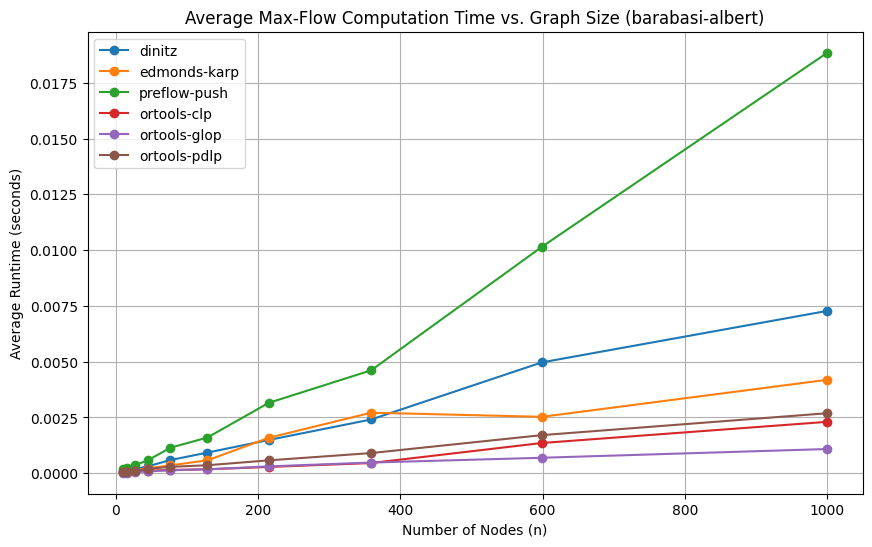

In [19]:
methods = [
    (max_flow_dinitz, 'dinitz'),
    (max_flow_edmonds_karp, 'edmonds-karp'),
    (max_flow_preflow_push, 'preflow-push'),
    (lp_solvers.max_flow_ortools_CLP, 'ortools-clp'),
    (lp_solvers.max_flow_ortools_GLOP, 'ortools-glop'),
    (lp_solvers.max_flow_ortools_PDLP, 'ortools-pdlp'),
    # (lp_solvers.max_flow_pulp_GLPK_primal, 'pulp-glpk-primal'),
    # (lp_solvers.max_flow_pulp_GLPK_dual, 'pulp-glpk-dual'),
    # (lp_solvers.max_flow_pulp_GLPK_barrier, 'pulp-glpk-barrier')
]

run_solvers_granular(methods, "./graphs/barabasi-albert")

In [10]:
import pulp as pl
solver_list = pl.listSolvers(onlyAvailable=True)
print(solver_list)

pl.pulpTestAll()

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.......

['GLPK_CMD', 'PULP_CBC_CMD']
Available solvers: ['GLPK_CMD', 'PULP_CBC_CMD']
Unavailable solvers: {'MIPCL_CMD', 'XPRESS_PY', 'COPT', 'MOSEK', 'HiGHS', 'CPLEX_PY', 'SCIP_CMD', 'COPT_CMD', 'PYGLPK', 'COIN_CMD', 'GUROBI_CMD', 'CHOCO_CMD', 'XPRESS', 'CPLEX_CMD', 'COPT_DLL', 'HiGHS_CMD', 'COINMP_DLL', 'GUROBI', 'SCIP_PY', 'FSCIP_CMD'}


.........................................................ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss....

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /var/folders/k4/mb2fyy7n1vb5ll6wsz6gxzt00000gn/T/48279ef4811e40d2900fe4cbdd4b9413-pulp.lp
 -o /var/folders/k4/mb2fyy7n1vb5ll6wsz6gxzt00000gn/T/48279ef4811e40d2900fe4cbdd4b9413-pulp.sol
Reading problem data from '/var/folders/k4/mb2fyy7n1vb5ll6wsz6gxzt00000gn/T/48279ef4811e40d2900fe4cbdd4b9413-pulp.lp'...
4 rows, 4 columns, 7 non-zeros
12 lines were read
GLPK Simplex Optimizer 5.0
4 rows, 4 columns, 7 non-zeros
Preprocessing...
1 row, 2 columns, 2 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 1
      0: obj =   5.000000000e+01 inf =   4.000e+00 (1)
      1: obj =   5.400000000e+01 inf =   0.000e+00 (0)
*     2: obj =   5.400000000e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.0 Mb (40400 bytes)
Writing basic solution to '/var/f

.....................................................

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/danielli/harvard/fa24/am205/project/.venv/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/k4/mb2fyy7n1vb5ll6wsz6gxzt00000gn/T/78273326853443a7ab6af6ee1053ad51-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/k4/mb2fyy7n1vb5ll6wsz6gxzt00000gn/T/78273326853443a7ab6af6ee1053ad51-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 20 RHS
At line 25 BOUNDS
At line 29 ENDATA
Problem MODEL has 4 rows, 4 columns and 7 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 1 (-3) rows, 2 (-2) columns and 2 (-5) elements
0  Obj 51.9 Primal inf 2.099999 (1)
1  Obj 54
Optimal - objective value 54
After Postsolve, objective 54, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 54 - 1 iterations time 0.002, Presolve 0.00
Option for printingOptions 

.......ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss
----------------------------------------------------------------------
Ran 1348 tests in 24.230s

OK (skipped=1220)
